# <font color='#3E1485'>**Cassava Leaf Disease Classification**</font>


## <font color='#9271C3'>背景</font>

キャッサバは世界の多くの地域で主要な主食作物の一つである。その人気の主な理由の一つは、干ばつなどの過酷な条件に対する耐性である。しかし、キャッサバは依然として病気にかかりやすく、作物の収量に大きな影響を与える可能性がある。病気を正しく特定することが治療を成功させる第一歩だが、多くの農家はそのための専門知識が不足している。病害の迅速な特定を可能にするツールは、健全な植物への被害を抑える上で特に有用であろう。

## <font color='#9271C3'>課題</font>

あなたはキャッサバの植物の画像を与えられ、植物が健康かどうかを判断し、4種類の病気を見分けるという課題を与えられています。

## <font color='#9271C3'>データ</font>

* `train.csv` - コメントとそのラベルを含むファイル。
* `test.csv` - テストデータを含むファイル。
* `sample_submission.csv` - サンプル提出ファイルを含むファイルであり、提出ファイルで期待されるカラムを示すために使用される。
* `test_labels.csv` - コンペティション終了後に公開されたテストデータのラベル。

## <font color='#9271C3'>お役立ちリンク集</font>

[コンペHP](https://www.kaggle.com/competitions/cassava-leaf-disease-classification)

[データ解説](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data)

[1位解答](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/discussion/221957)

[2位解答](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/discussion/220898)

[3位解答](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/discussion/221150)

# <font color='#3E1485'>**セットアップ**</font>

以下のセルは必要なデータをダウンロードし、ノートブックで使用する環境を設定します。

## <font color='#9271C3'>GPUランタイムを有効にする</font>

このノートブックはGPUを搭載したシステムで実行するように設計されています。ランタイムのタイプをGPUを含むものに切り替えていることを確認してください（例：A100、V100）。

GPUランタイムを使用しているかどうかを確認するには、次のセルを実行してください。フォーマットされたテキストが複数行出力されるはずです。

In [ ]:
!nvidia-smi

## <font color='#9271C3'>データセットをダウンロードする</font>

Kaggleはコンペティションと簡単にやり取りできるAPIを提供しています。私たちはこのAPIを使って自動的にデータをダウンロードし、予測をアップロードします。

このAPIを使用する最初のステップは、自分のユーザーとして認証することです。APIトークンはユーザー名とKaggleが生成したキーを含むファイルです。トークンはアカウントページからダウンロードすることができ、通常 `kaggle.json` と呼ばれます。APIトークンは、あなたのユーザーとしてAPIにアクセスするために必要なものなので、個人のGoogle Driveフォルダに安全に保管してください。

このノートブックはGoogle Driveフォルダ内の`kaggle.json`というKaggle APIトークンを検索します。トークンをGoogle Driveに置いたことを確認し、プロンプトが表示されたらこのノートブックがトークンにアクセスすることを許可してください。

認証後、参加したすべてのコンペティションにアクセスできます。データのダウンロードにエラーが発生した場合は、Kaggle API トークンが有効であること、コンペティションのルールに同意していることを確認してください。

In [ ]:
from google.colab import drive
import os
import json

drive.mount("/content/drive", force_remount=True)
fin = open("/content/drive/MyDrive/kaggle.json", "r")
json_data = json.load(fin)
fin.close()
os.environ["KAGGLE_USERNAME"] = json_data["username"]
os.environ["KAGGLE_KEY"] = json_data["key"]

データが大きいため、ダウンロードと解凍に数分かかる場合があります。

In [ ]:
%%bash
kaggle competitions download -c cassava-leaf-disease-classification
if [ $? -ne 0 ]; then
    echo "データのダウンロードに問題があったようです。"
    echo "競技規則に同意し、APIキーが有効であることを確認してください。"
else
    mkdir -p /content/kaggle
    unzip -q -o /content/cassava-leaf-disease-classification.zip -d /content/kaggle
fi
wget -q -P /tmp https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
unzip -o /tmp/NotoSansCJKjp-hinted.zip -d /usr/share/fonts/NotoSansCJKjp

## <font color='#9271C3'>環境</font>

デフォルトではインストールされていないライブラリを使用するので、ここでインストールします。

In [ ]:
!pip install pytorch-lightning timm

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pytorch_lightning as pl
from tqdm.auto import tqdm
import torchmetrics
from glob import glob
import json
from PIL import Image
import multiprocessing as mp
import torchvision
import timm

font_path = '/usr/share/fonts/NotoSansCJKjp/NotoSansMonoCJKjp-Regular.otf'
matplotlib.font_manager.fontManager.addfont(font_path)
prop = matplotlib.font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
os.chdir('/content/kaggle')

# <font color='#3E1485'>**視覚化**</font>

この競技では、植物の画像と病気の存在を示すラベルが与えられる。

## <font color='#9271C3'>label_num_to_disease_map.json</font>

トレーニングデータで提供されるラベルは数値です。このファイルはラベルから病名へのマッピングを提供します。

In [ ]:
with open('label_num_to_disease_map.json', 'r') as fh:
    diseases = json.loads(fh.read())
diseases

## <font color='#9271C3'>train.csv</font>

In [ ]:
data = pd.read_csv('/content/kaggle/train.csv')
data

このファイルは単にファイル名とそれに対応するラベルのリストである。

まず、それぞれの病気の例を健康な植物とともに見てみよう。

In [ ]:
for label, disease in diseases.items():
    plt.figure()
    filename = data[data['label']==int(label)].sample(1)['image_id'].values[0]
    with Image.open(f'train_images/{filename}') as image:
        plt.imshow(image)
        plt.title(disease)

次にラベルの分布を見てみよう。

In [ ]:
data_bar = data.copy()
data_bar.loc[data_bar['label']==0, 'label'] = 'Cassava\n Bacterial\nBlight'
data_bar.loc[data_bar['label']==1, 'label'] = 'Cassava\nBrown\nStreak\nDisease'
data_bar.loc[data_bar['label']==2, 'label'] = 'Cassava\nGreen\nMottle'
data_bar.loc[data_bar['label']==3, 'label'] = 'Cassava\nMosaic\nDisease'
data_bar.loc[data_bar['label']==4, 'label'] = 'Healthy'
sns.countplot(data_bar, x='label')
plt.xlabel(None)
plt.ylabel(None);

分類タスクの多くの場合とは異なり、「健康な」クラスが最も一般的なクラスではないことがわかる。実際、`カッサバ・モザイク病`は、他のすべてのクラスを合わせたのと同じくらい頻度が高いように見える。

# <font color='#3E1485'>**モデリング**</font>

このノートでは、画像分類タスクでよく使われる画像モデルEfficientNetを使います。モデルと事前学習された重みは `timm` ライブラリから読み込みます。PyTorchとPyTorch Lightningも使います。PyTorchはディープラーニングでよく使われるライブラリで、モデルの作成と学習ができます。

## <font color='#9271C3'>前処理</font>

トレーニング用のデータセットを準備するために必要な前処理はあまりありません。単純に画像をファイルから読み込み、サイズを小さくするだけです。

データセットは約7GBとそれほど大きくはありませんが、一度にメモリにロードするには時間がかかるかもしれません。さらに、ディスク上の画像は圧縮されており、一度読み込まれたデータのサイズは7GBより大きくなる可能性が高い。長時間の前処理を避け、メモリエラーのリスクを減らすために、PyTorch の `DataSet` オブジェクトを介してアクセスされた画像を読み込みます。

High-RAM オプションを有効にした A100 ランタイムタイプを選択していることを確認してください。この組み合わせにより、多くのプロセッサを持つシステムを利用できるようになり、多くの画像を並列処理することでオンザフライ処理のコストを相殺することができます。

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, labels=None):
        if labels is not None:
            self.labels = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=5).float()
        else:
            self.labels = None
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        with Image.open(f'train_images/{filename}') as pil_image:
            image = torchvision.transforms.functional.pil_to_tensor(pil_image)
        image = torchvision.transforms.functional.resize(image, (256, 256), antialias=True)
        image = image.float() / 255
        if self.labels is None:
            return image
        else:
            return image, self.labels[idx]

ds = CustomDataset(data['image_id'].values, data['label'].values)

## <font color='#9271C3'>トレーニング</font>

今回使用するモデルは、別のタスクのためにすでに学習済みです。単にモデルを初期化し、データセットのクラスの値を出力するように変更します。その後、モデルを微調整し、タスクのためにモデルを再トレーニングします。

標準的なPyTorchでは、モデルやタスクに関係なく同じテンプレートコードを書きます。これは非常に面倒であり、また細かい部分を忘れやすいためエラーが起こりやすい。PyTorch Lightningを使えば、学習コードの最も関連性の高い部分を1つのクラスにまとめ、細かい部分はライブラリに任せることができます。さらに、PyTorch Lightningはロギング、チェックポイント、その他のタスクのための多くの便利なユーティリティを提供します。

以下のセルでは、以下のメソッドを含む PyTorch Lightning の `LightningModule` を定義します：
- `__init__` - 学習中に使用する変数を初期化します。これにはモデルとトレーニングの進捗を監視するためのメトリクスが含まれます。
- `forward` - 与えられた入力をどのようにモデルに渡すかを定義する。
- `(training|validation)_step` - 各ステップで実行するアクションを定義します。最も単純なケースでは `forward` を呼び出して損失を計算するが、追加の後処理やロギングを含めることもできる。
- `configure_optimizers` - トレーニング中に使用するオプティマイザを返す。

In [ ]:
class CustomModel(pl.LightningModule):
    def __init__(self, lr=1e-5):
        super().__init__()
        self.lr = lr
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=5)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.train_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=5)
        self.val_accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=5)

    def forward(self, images):
        return self.model(images)

    def training_step(self, batch, batch_idx):
        image, labels = batch
        preds = self.forward(image)
        loss = self.loss_fn(preds, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.train_accuracy(preds.softmax(1), labels.argmax(1))
        self.log('train_accuracy', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        image, labels = batch
        preds = self.forward(image)
        loss = self.loss_fn(preds, labels)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.val_accuracy(preds.softmax(1), labels.argmax(1))
        self.log('val_accuracy', self.val_accuracy, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

モデルが学習しているかどうかを確認するには、トレーニング中のパフォーマンスをモニターする必要がある。具体的には、時間の経過とともに損失が減少していること、追跡しているメトリクスに改善が見られることを確認したい。

ここでは、TensorBoardを使用してトレーニングを監視します。TensorBoardは、時間の経過とともにモデルのパフォーマンスを可視化する便利なツールです。

TensorBoardサーバーを起動するには、以下のセルを実行します。数秒後、インターフェースが表示されます。トレーニングやロギング値を開始していないため、最初は何も出力されません。トレーニングが開始されると、セルの出力は定期的に更新されます。

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

トレーニングの準備はほぼ整いました。次のセルでは、まずデータを学習セットと検証セットに分割し、データをバッチ処理するPyTorchの `DataLoader` を準備します。次に、モデルとロガーを初期化し、モデルの最適な反復を保存するコールバックを作成します。最後に、学習を開始します。

In [ ]:
train_ds, val_ds = torch.utils.data.random_split(ds, [0.8, 0.2])
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=mp.cpu_count())
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=mp.cpu_count())

model = CustomModel()
tb_logger = pl.loggers.TensorBoardLogger('lightning_logs', name='', version='custom_model')
if os.path.exists(f'lightning_logs/{tb_logger.version}/checkpoints'):
    for checkpoint in os.listdir(f'lightning_logs/{tb_logger.version}/checkpoints/'):
        os.remove(f'lightning_logs/{tb_logger.version}/checkpoints/{checkpoint}')
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_accuracy', mode='max')
trainer = pl.Trainer(
    max_epochs=5, accelerator='gpu', precision='16-mixed',
    logger=tb_logger,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True
)

trainer.fit(model, train_dl, val_dl)

## <font color='#9271C3'>Kaggleへのアップロード</font>

このコンペティションは「カーネルコンペティション」であり、テストデータに直接アクセスすることはできません。代わりに、競技者は完全なテストデータを含む環境でKaggleによって実行されるコードを提出することが期待されています。これはコンペティションをより公平にするために行われていることですが、システムに慣れていない参加者にとっては混乱や複雑さを引き起こす可能性があります。

この種のコンペティションでよく行われるのは
1. 競技データでモデルをトレーニングする。
2. トレーニングしたモデルをデータセットとしてKaggleにアップロードする。
3. Kaggle上でデータセットから学習済みモデルをロードするノートブックを作成する。
4. データセットを更新する

### 学習済みモデルのアップロード

前のセルでモデルをトレーニングしたので、モデルのアップロードに移ります。次のセルでは、Kaggle APIを使ってプライベートデータセットを自動的に作成し、アップロードします。このセルを続けて実行すると、データセットが更新されます。

Kaggle APIはあなたのデータセットへのリンクを出力します。それをクリックしてデータセットにアクセスし、正常に作成されたことを確認してください。

In [ ]:
%%bash
dataset_name="cassava-project-dataset-$KAGGLE_USERNAME"
dataset_dir="/content/kaggle/$dataset_name"
dataset_meta_path="$dataset_dir/dataset-metadata.json"
mkdir -p "$dataset_dir"
cp lightning_logs/custom_model/checkpoints/*.ckpt "$dataset_dir/checkpoint.ckpt"
kaggle datasets init -p "$dataset_dir"
sed -i "s/INSERT_TITLE_HERE/$dataset_name/g" "$dataset_meta_path"
sed -i "s/INSERT_SLUG_HERE/$dataset_name/g" "$dataset_meta_path"
dataset_exists=$(kaggle datasets list -m -s "$dataset_name" | grep "$dataset_name")
dataset_exists=$?
if [ $dataset_exists -eq "0" ]
then
    echo "Updating dataset"
    kaggle datasets version -p "$dataset_dir" -m "Version message"
else
    echo "Creating dataset"
    kaggle datasets create -p "$dataset_dir"
fi

### 競技用ノートブックの作成

学習済みモデルを含むデータセットを作成した後、競技会用のノートブックを作成します。

[このリンク](https://www.kaggle.com/competitions/cassava-leaf-disease-classification)をクリックすると、競技会場に移動します。

以下の画像を参考にノートブックを作成してください。

「Late Submission」をクリックして。

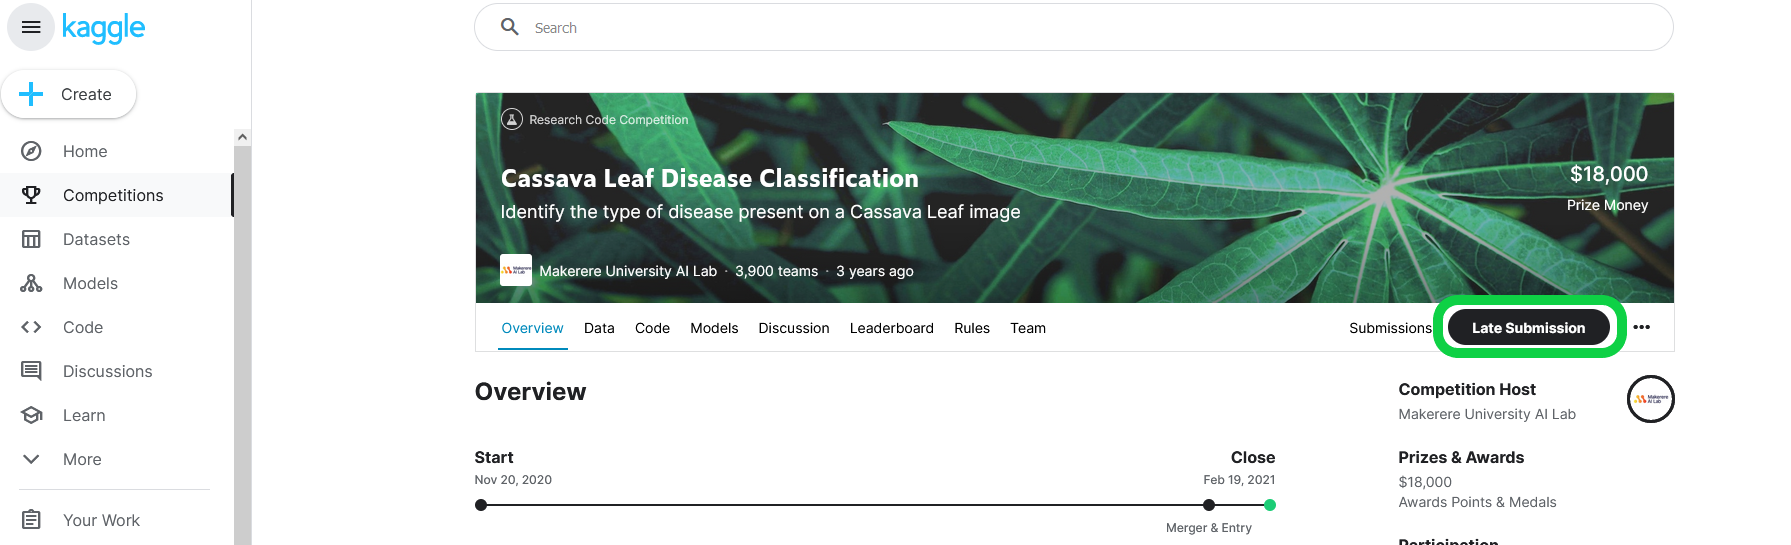

「New Notebook」をクリックします。

新しいノートブックが別のタブで開きます。

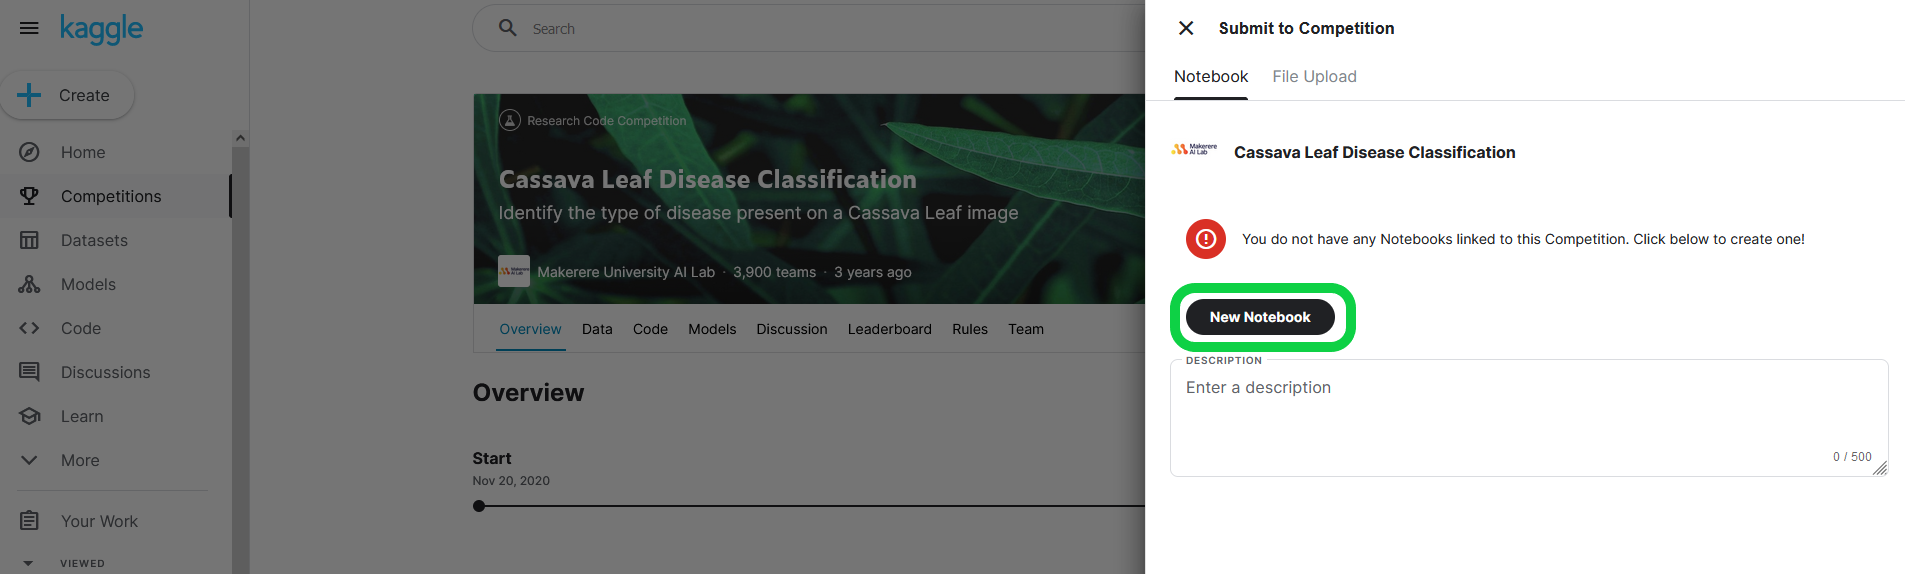

ノートブックにはKaggleによって生成された名前とテンプレートコードがあります。ノートブックの名前をもっと分かりやすいものに変更することをお勧めしますが、そのままでも問題ありません。

「Add Data」をクリックして。

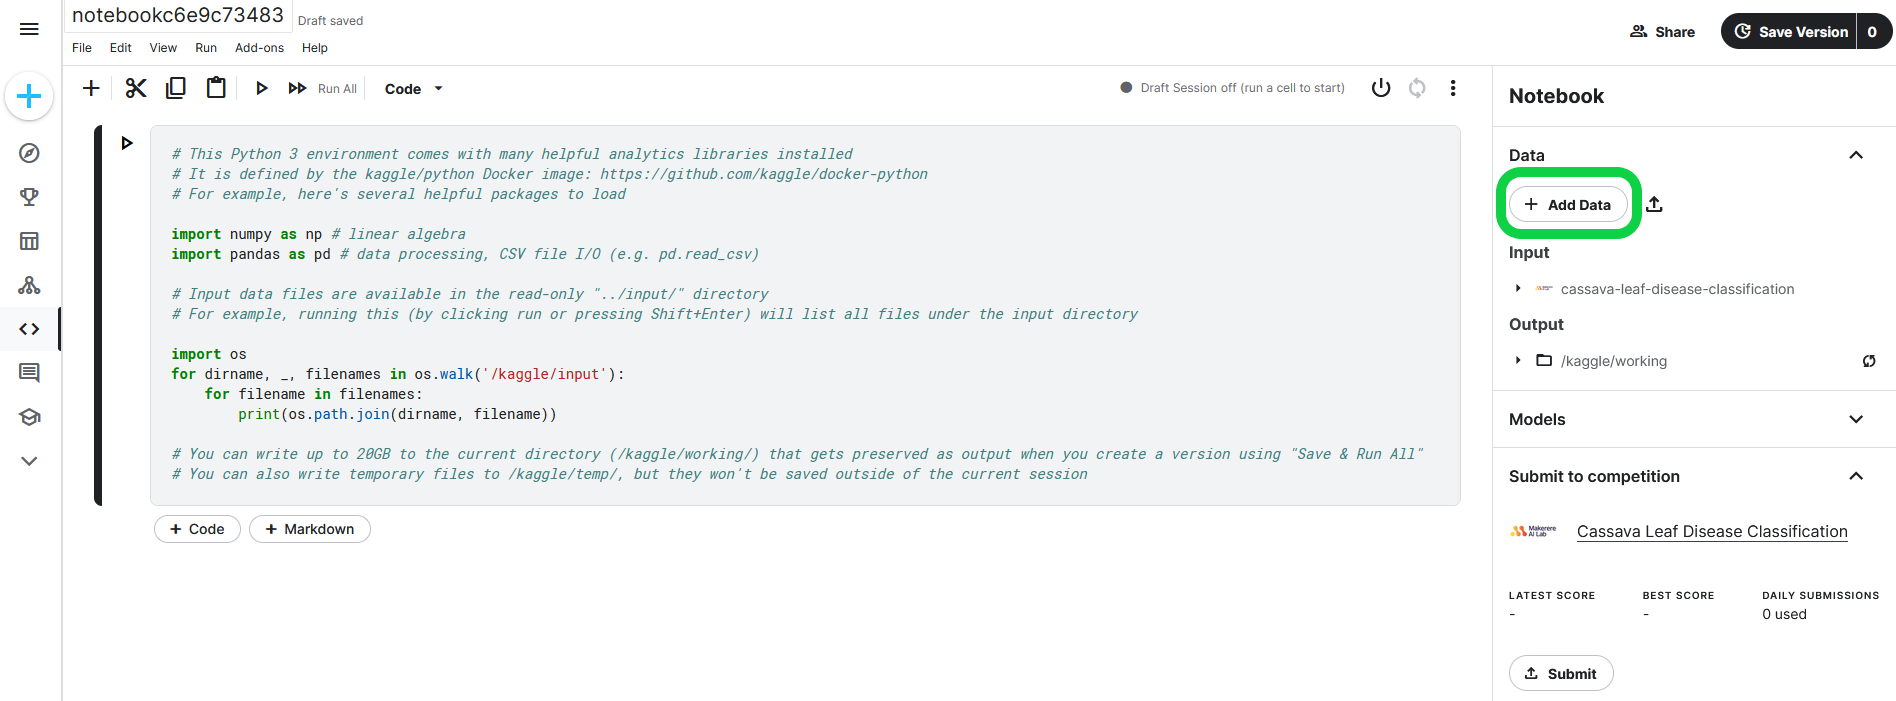

データセットには、`cassava-project-dataset-KAGGLE_USERNAME` のような名前が付けられているはずです。データセットのリストの一番上にあるはずですが、ない場合は「Your Datasets」をクリックすると表示されます。

「＋」をクリックしてデータセットを添付する。

次に、「X」をクリックして、「Add Data」タブを閉じる。

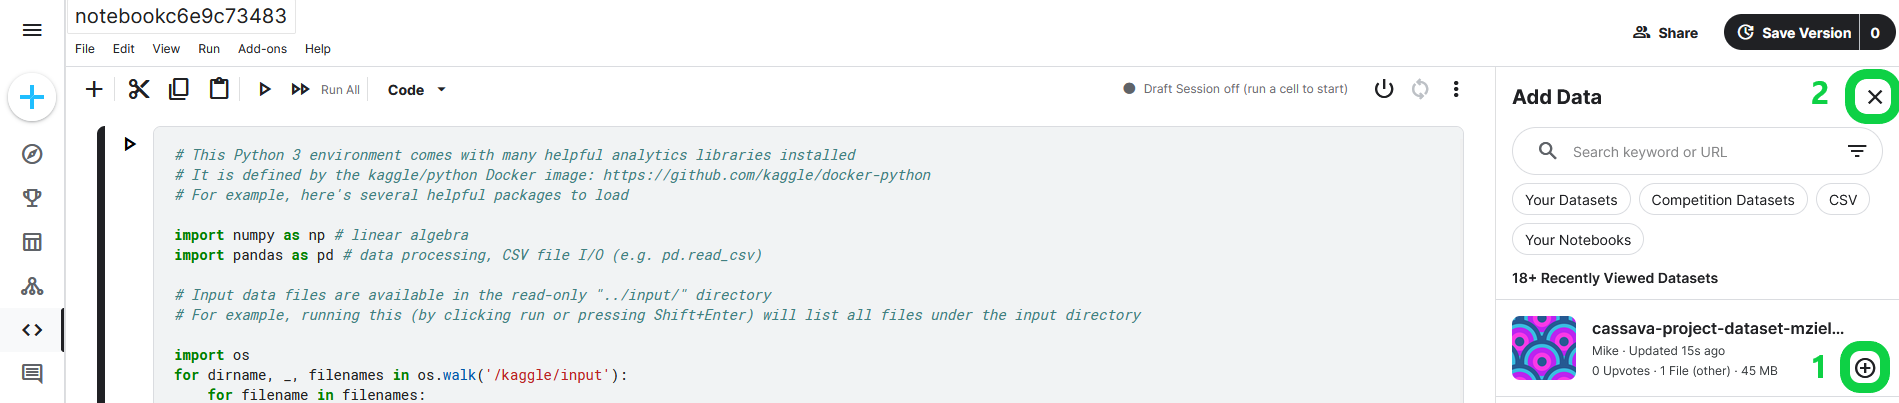

データセットが正常に追加されたことを確認します。

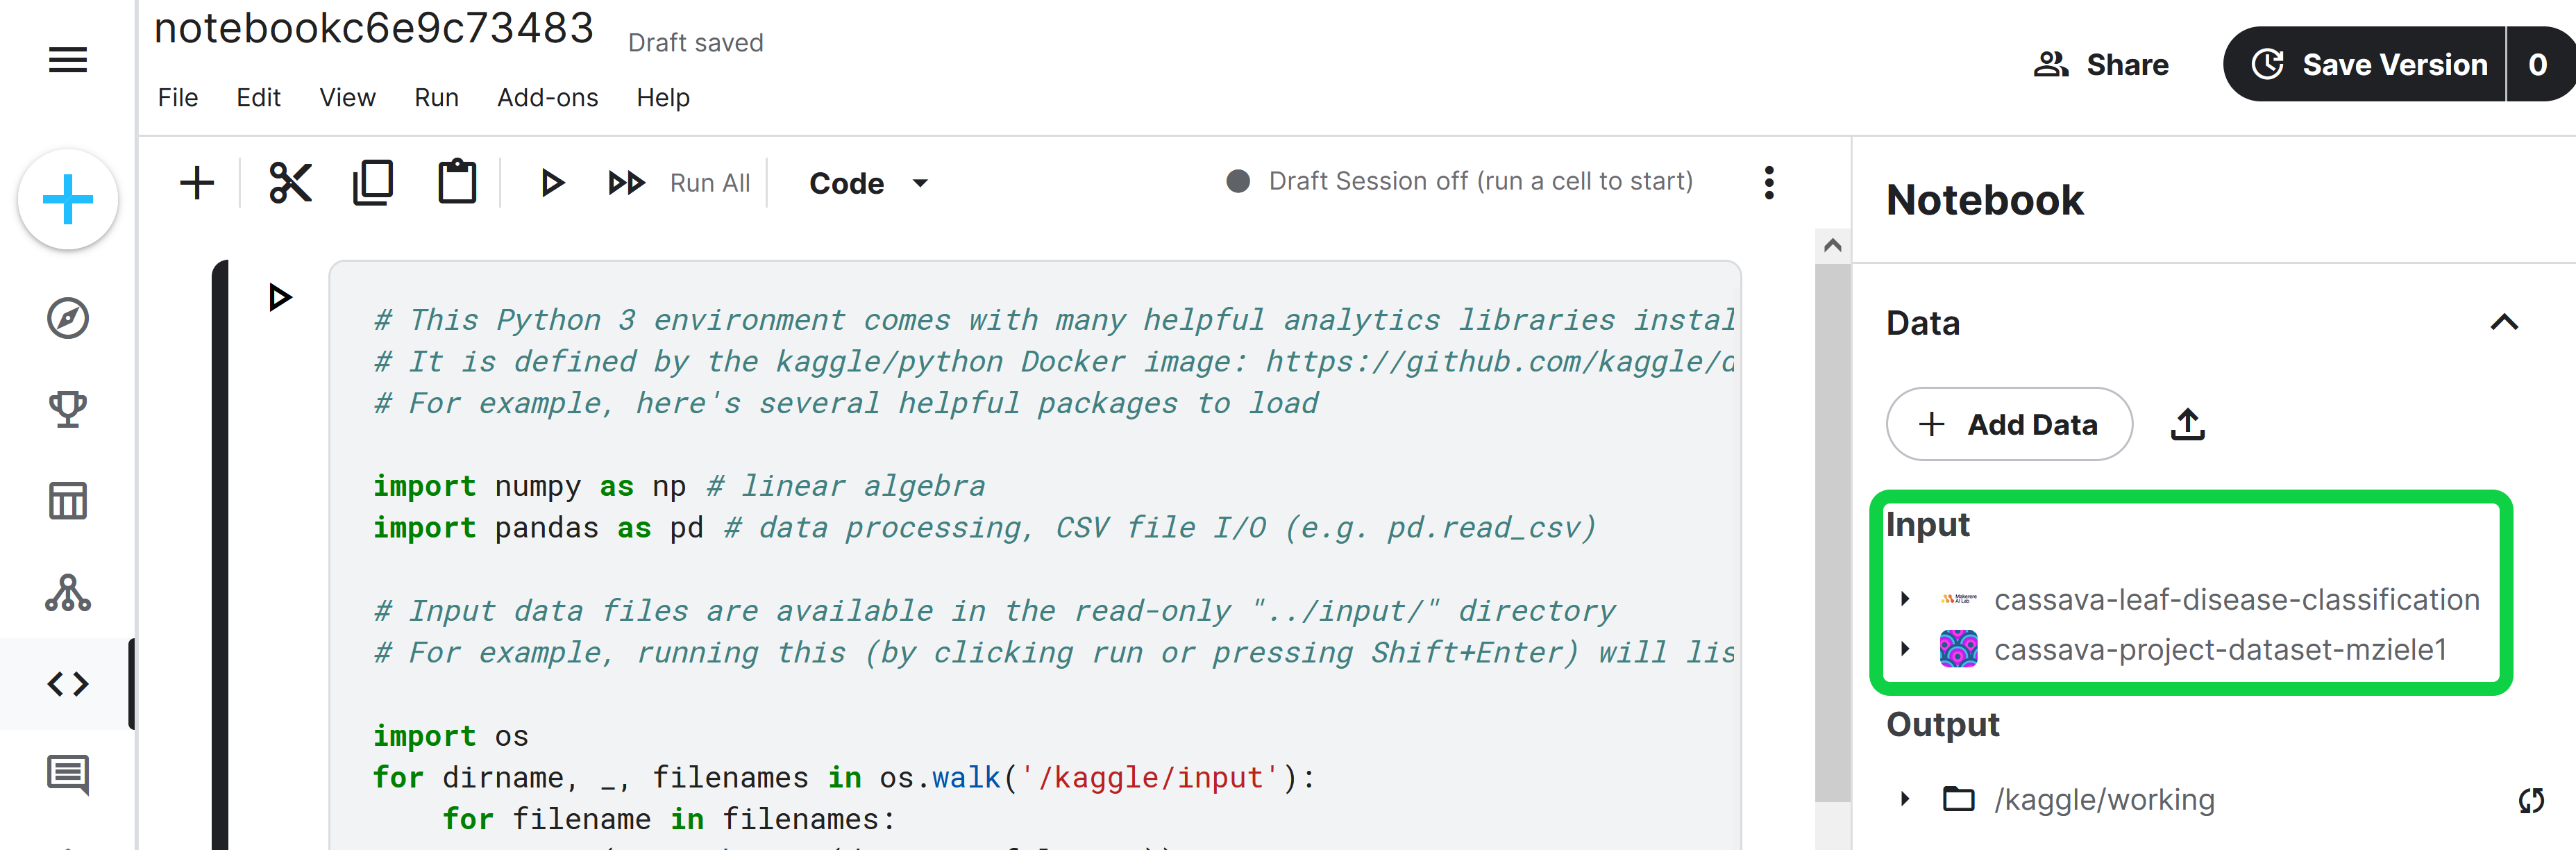

ノートブックのテンプレート・コードをすべて削除してください。空のコード・セルが残るはずです。

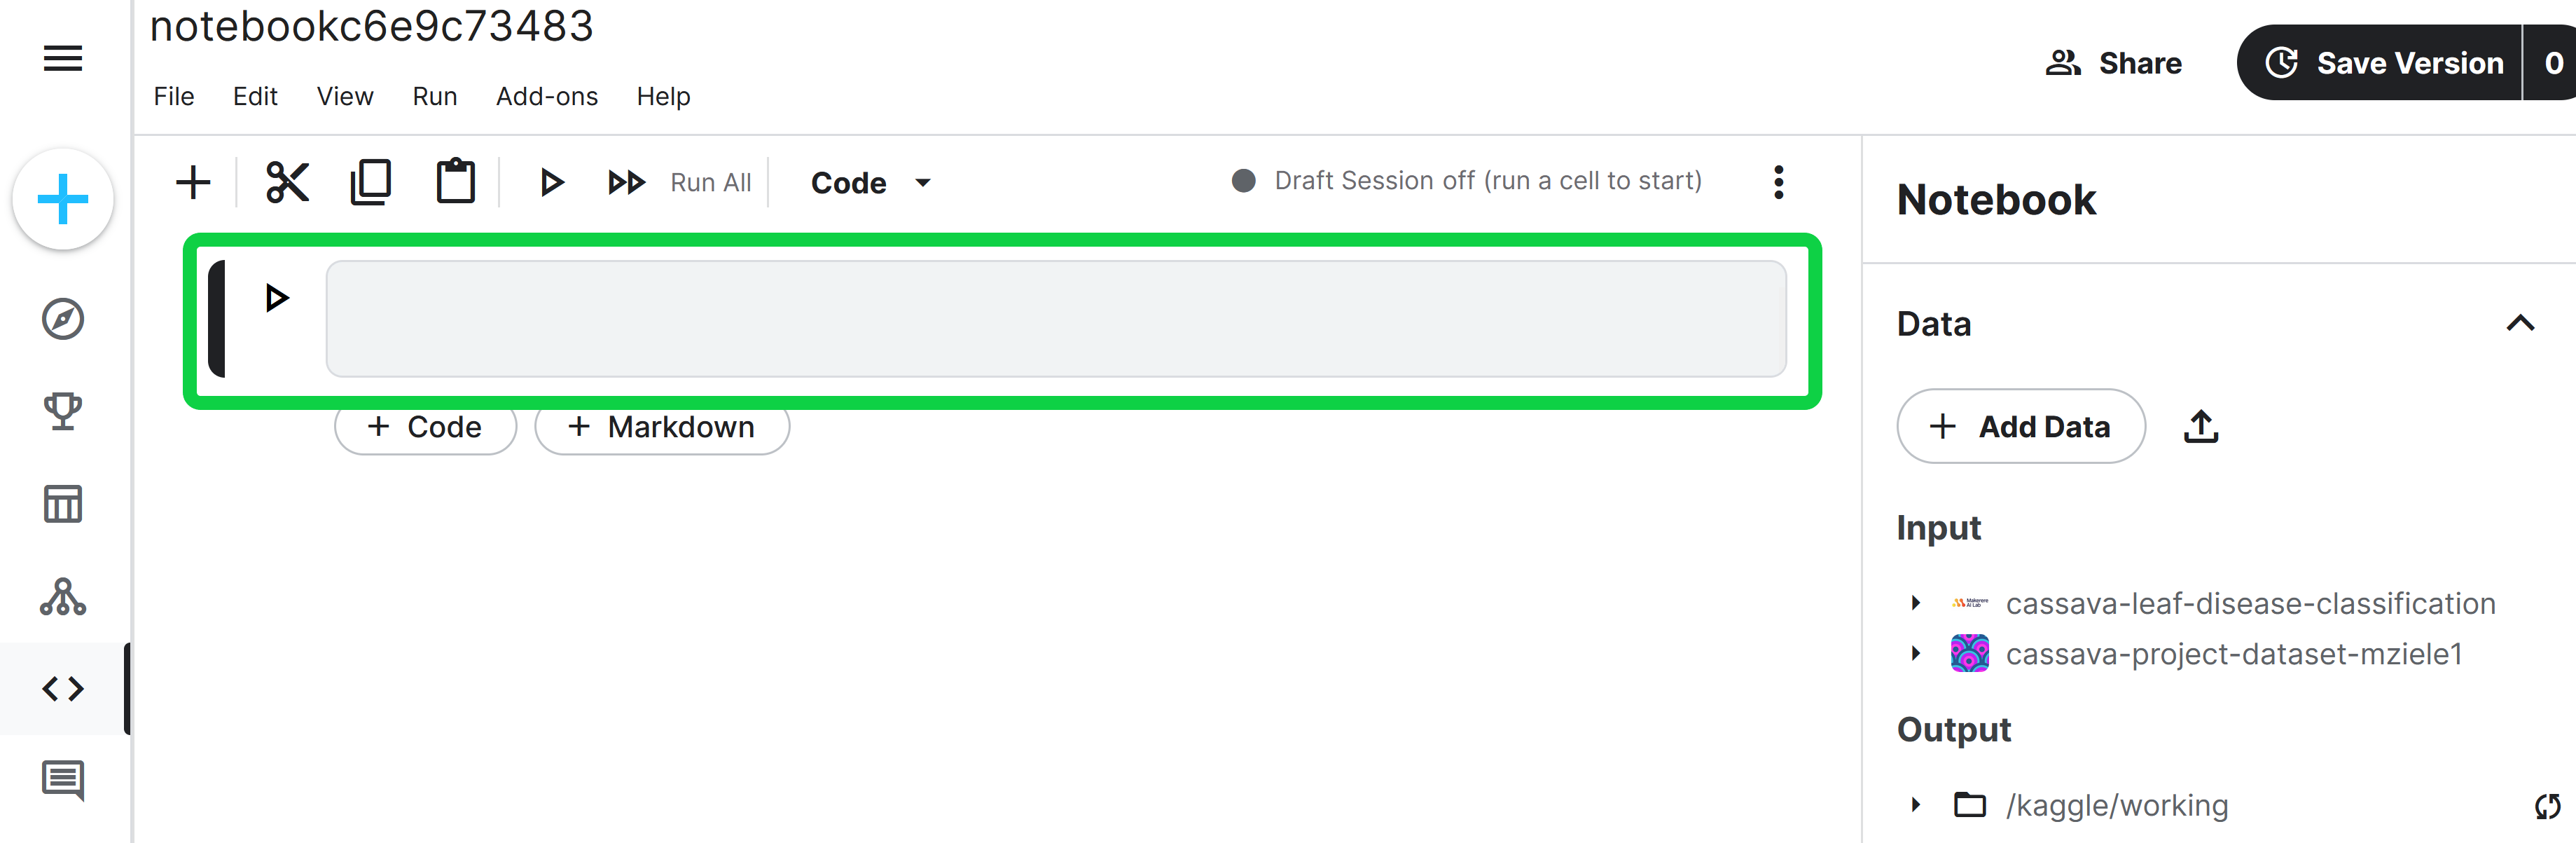

下のセルは、このノートブックで以前に作成したデータセットを使うようにカスタマイズされたパイソンコードを出力します。

このコードは基本的にこのノートブックのコードを凝縮し、少し修正したものです。トレーニングの代わりに、以下のコードはデータセットに含まれるモデルのチェックポイントをロードします。次にテスト画像をロードし、各疾患クラスの予測を生成します。最後に、予測値をファイル `submission.csv` に書き込みます。

In [ ]:
%%bash
dataset_name="cassava-project-dataset-$KAGGLE_USERNAME"
cat << EOF
import os
import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from PIL import Image
import multiprocessing as mp
import torchvision
import timm

test_filenames = os.listdir('/kaggle/input/cassava-leaf-disease-classification/test_images')

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, labels=None):
        if labels is not None:
            self.labels = torch.nn.functional.one_hot(torch.tensor(labels), num_classes=5).float()
        else:
            self.labels = None
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        with Image.open(f'/kaggle/input/cassava-leaf-disease-classification/test_images/{filename}') as pil_image:
            image = torchvision.transforms.functional.pil_to_tensor(pil_image)
        image = torchvision.transforms.functional.resize(image, (256, 256), antialias=True)
        image = image.float() / 255
        if self.labels is None:
            return image
        else:
            return image, self.labels[idx]

ds = CustomDataset(test_filenames)

class CustomModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=5)

    def forward(self, images):
        return self.model(images)

    def predict_step(self, batch, batch_idx):
        preds = self.forward(batch).softmax(1).argmax(1).detach().cpu()
        return preds


dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=False, num_workers=mp.cpu_count())

model = CustomModel.load_from_checkpoint('/kaggle/input/$dataset_name/checkpoint.ckpt')
trainer = pl.Trainer(
    accelerator='gpu', precision='16-mixed',
    logger=None, callbacks=None
)

preds = trainer.predict(model, dl)
submission = pd.DataFrame.from_dict({
    'image_id': test_filenames,
    'label': torch.cat(preds).numpy()
})
submission.to_csv('submission.csv', index=False)
EOF

上記の出力をKaggleノートブックにコピーします。すべての行をコピーするには、必要に応じてスクロールしてください。

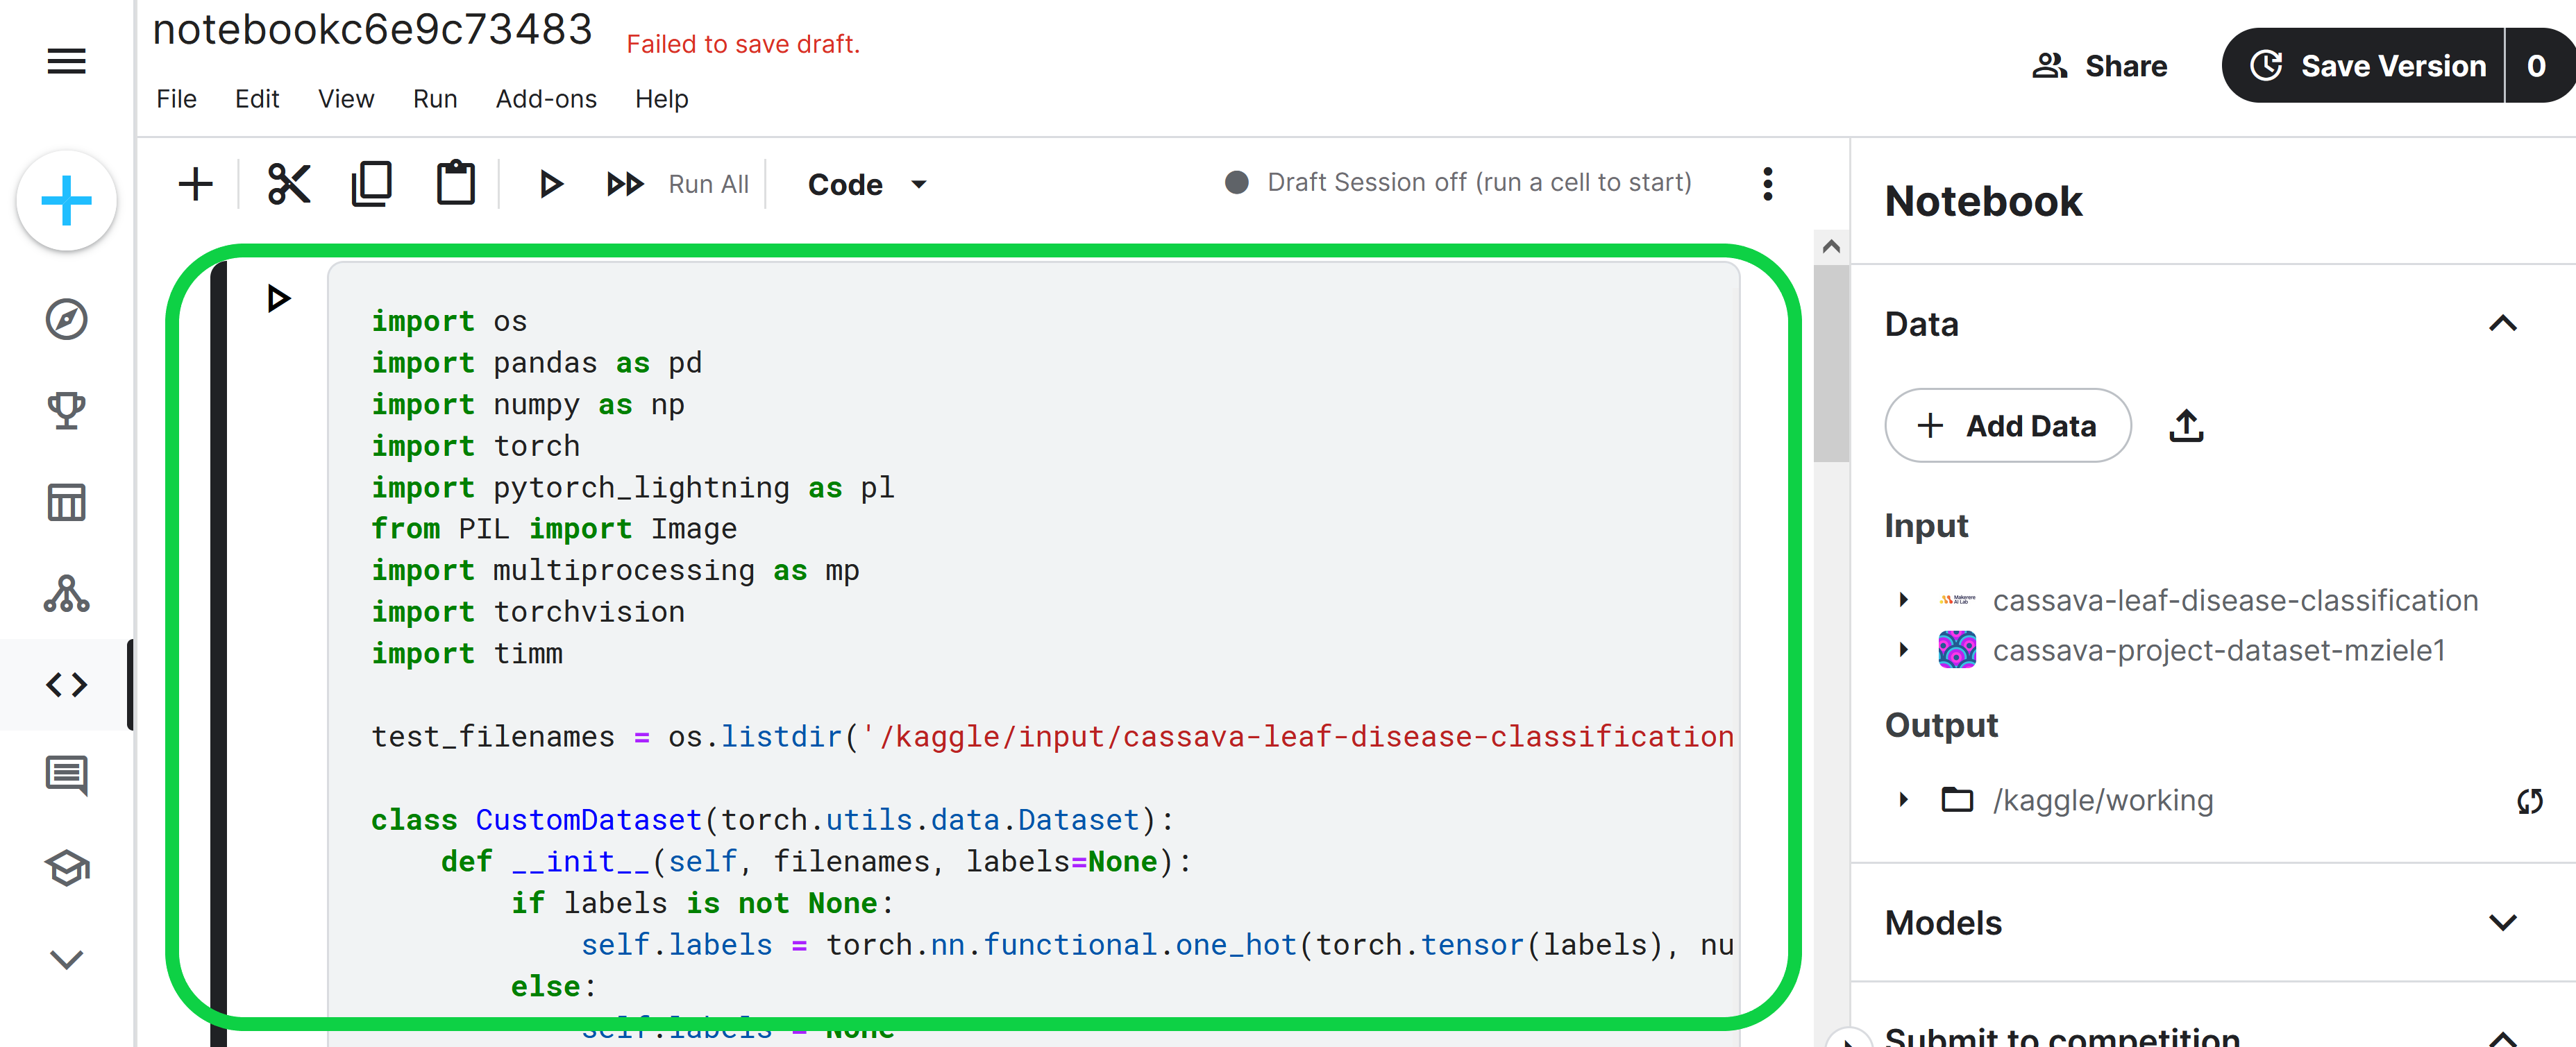

次に、GPUをノートブックで使えるようにし、インターネットアクセスを無効にする必要がある。これらのオプションはノートブックの右側、データタブの下にあります。

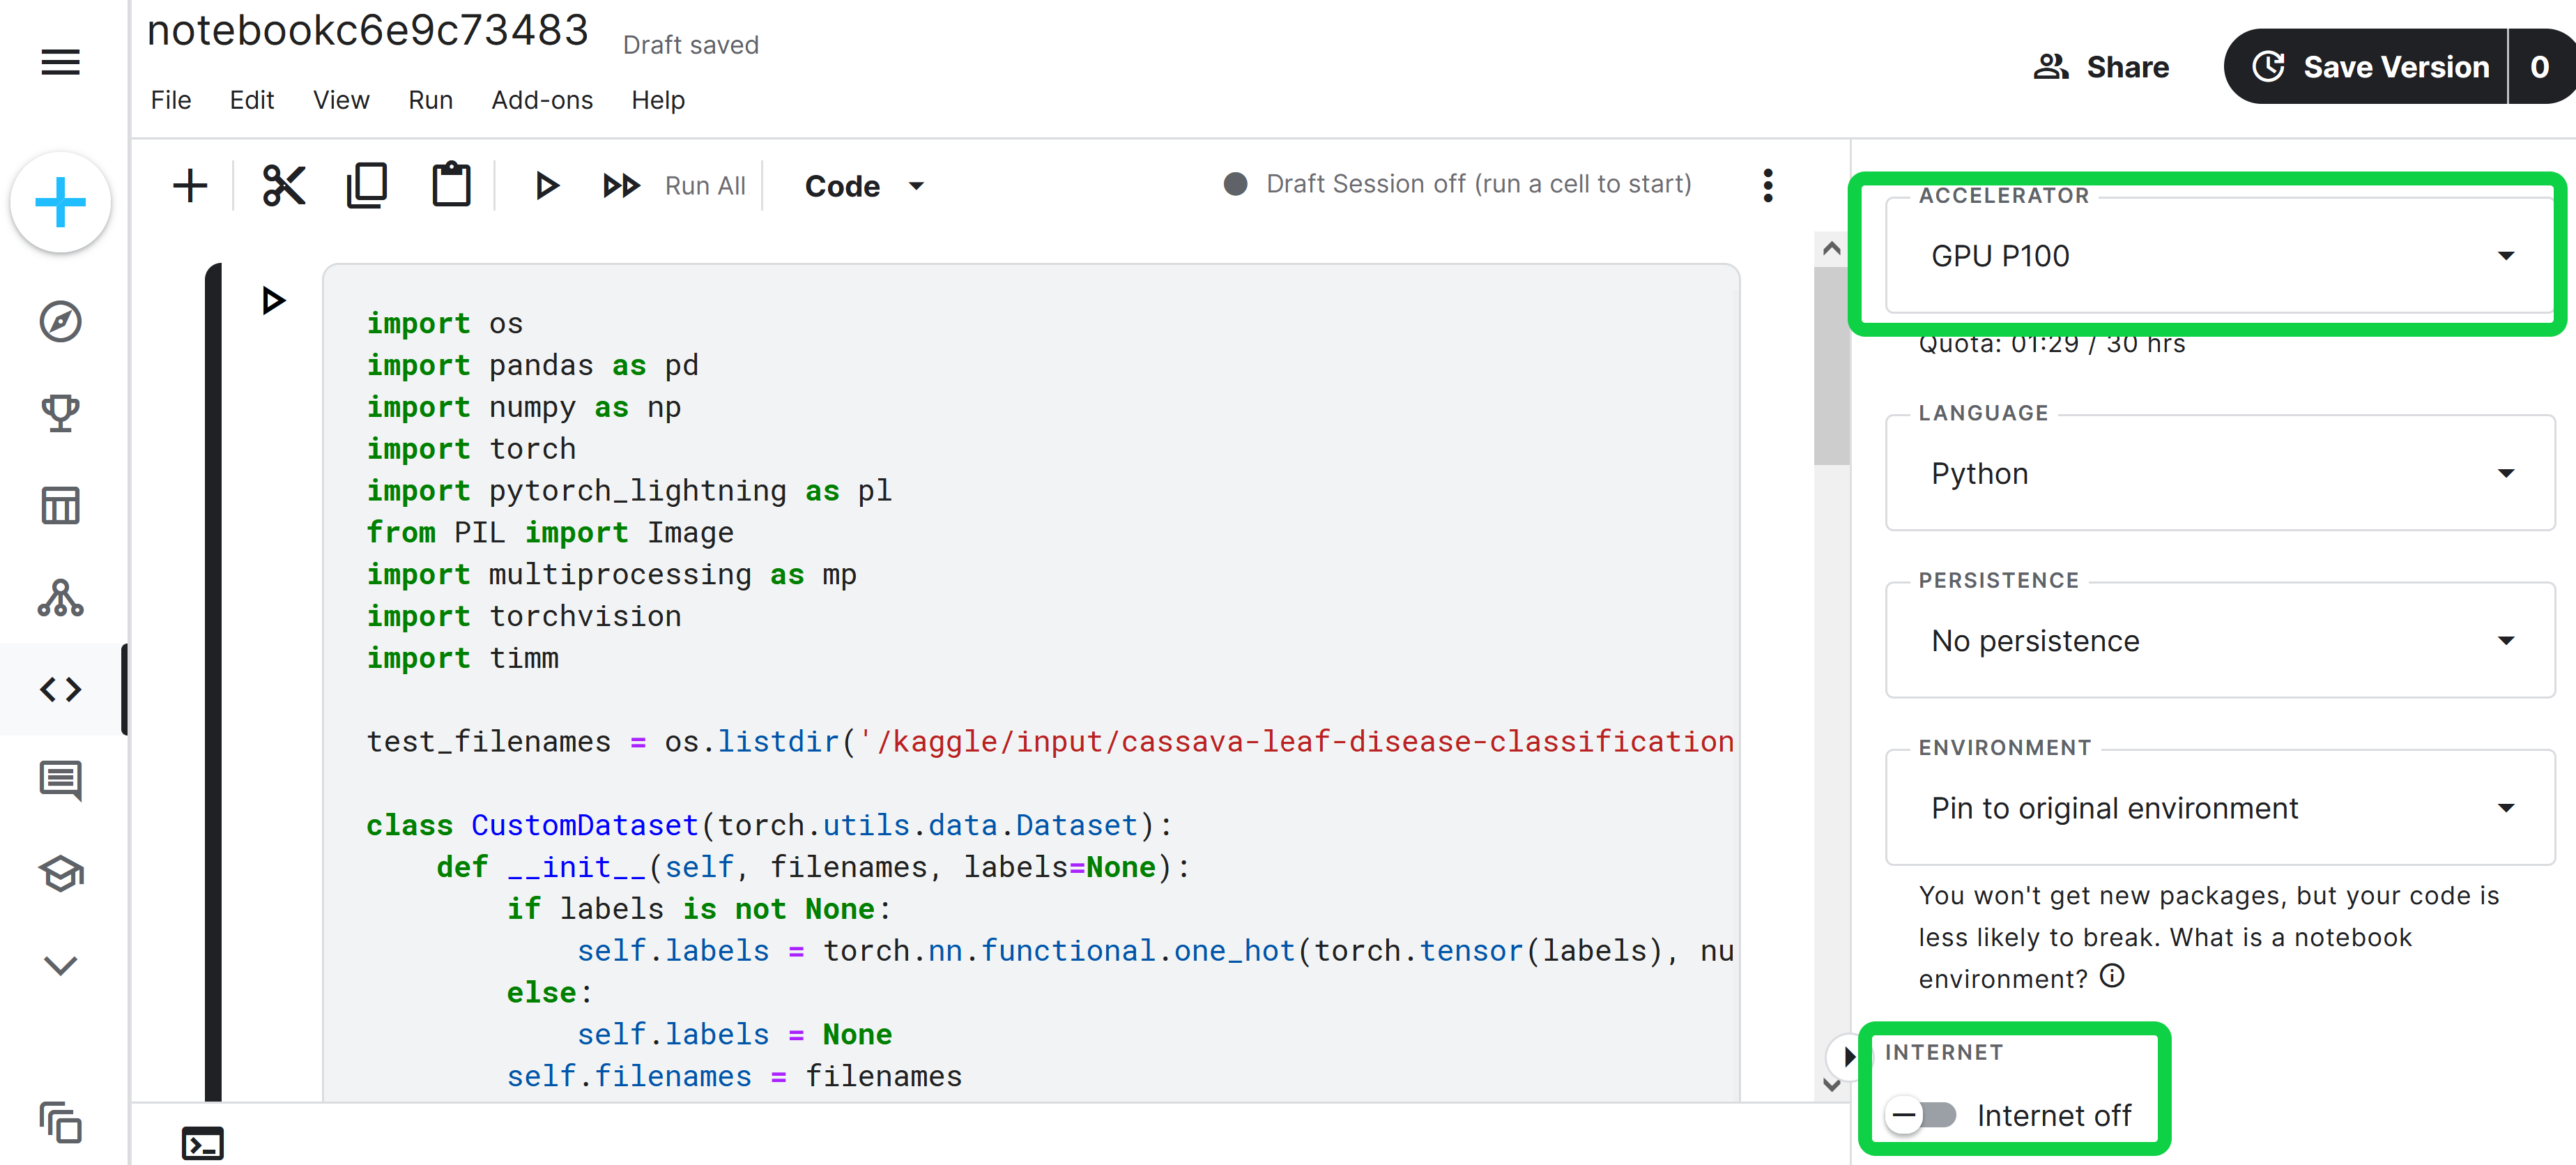


これでノートブックはセットアップされ、コンペティションに提出する準備が整いました。コンペティションに提出」セクションに移動し、「Submit」をクリックします。

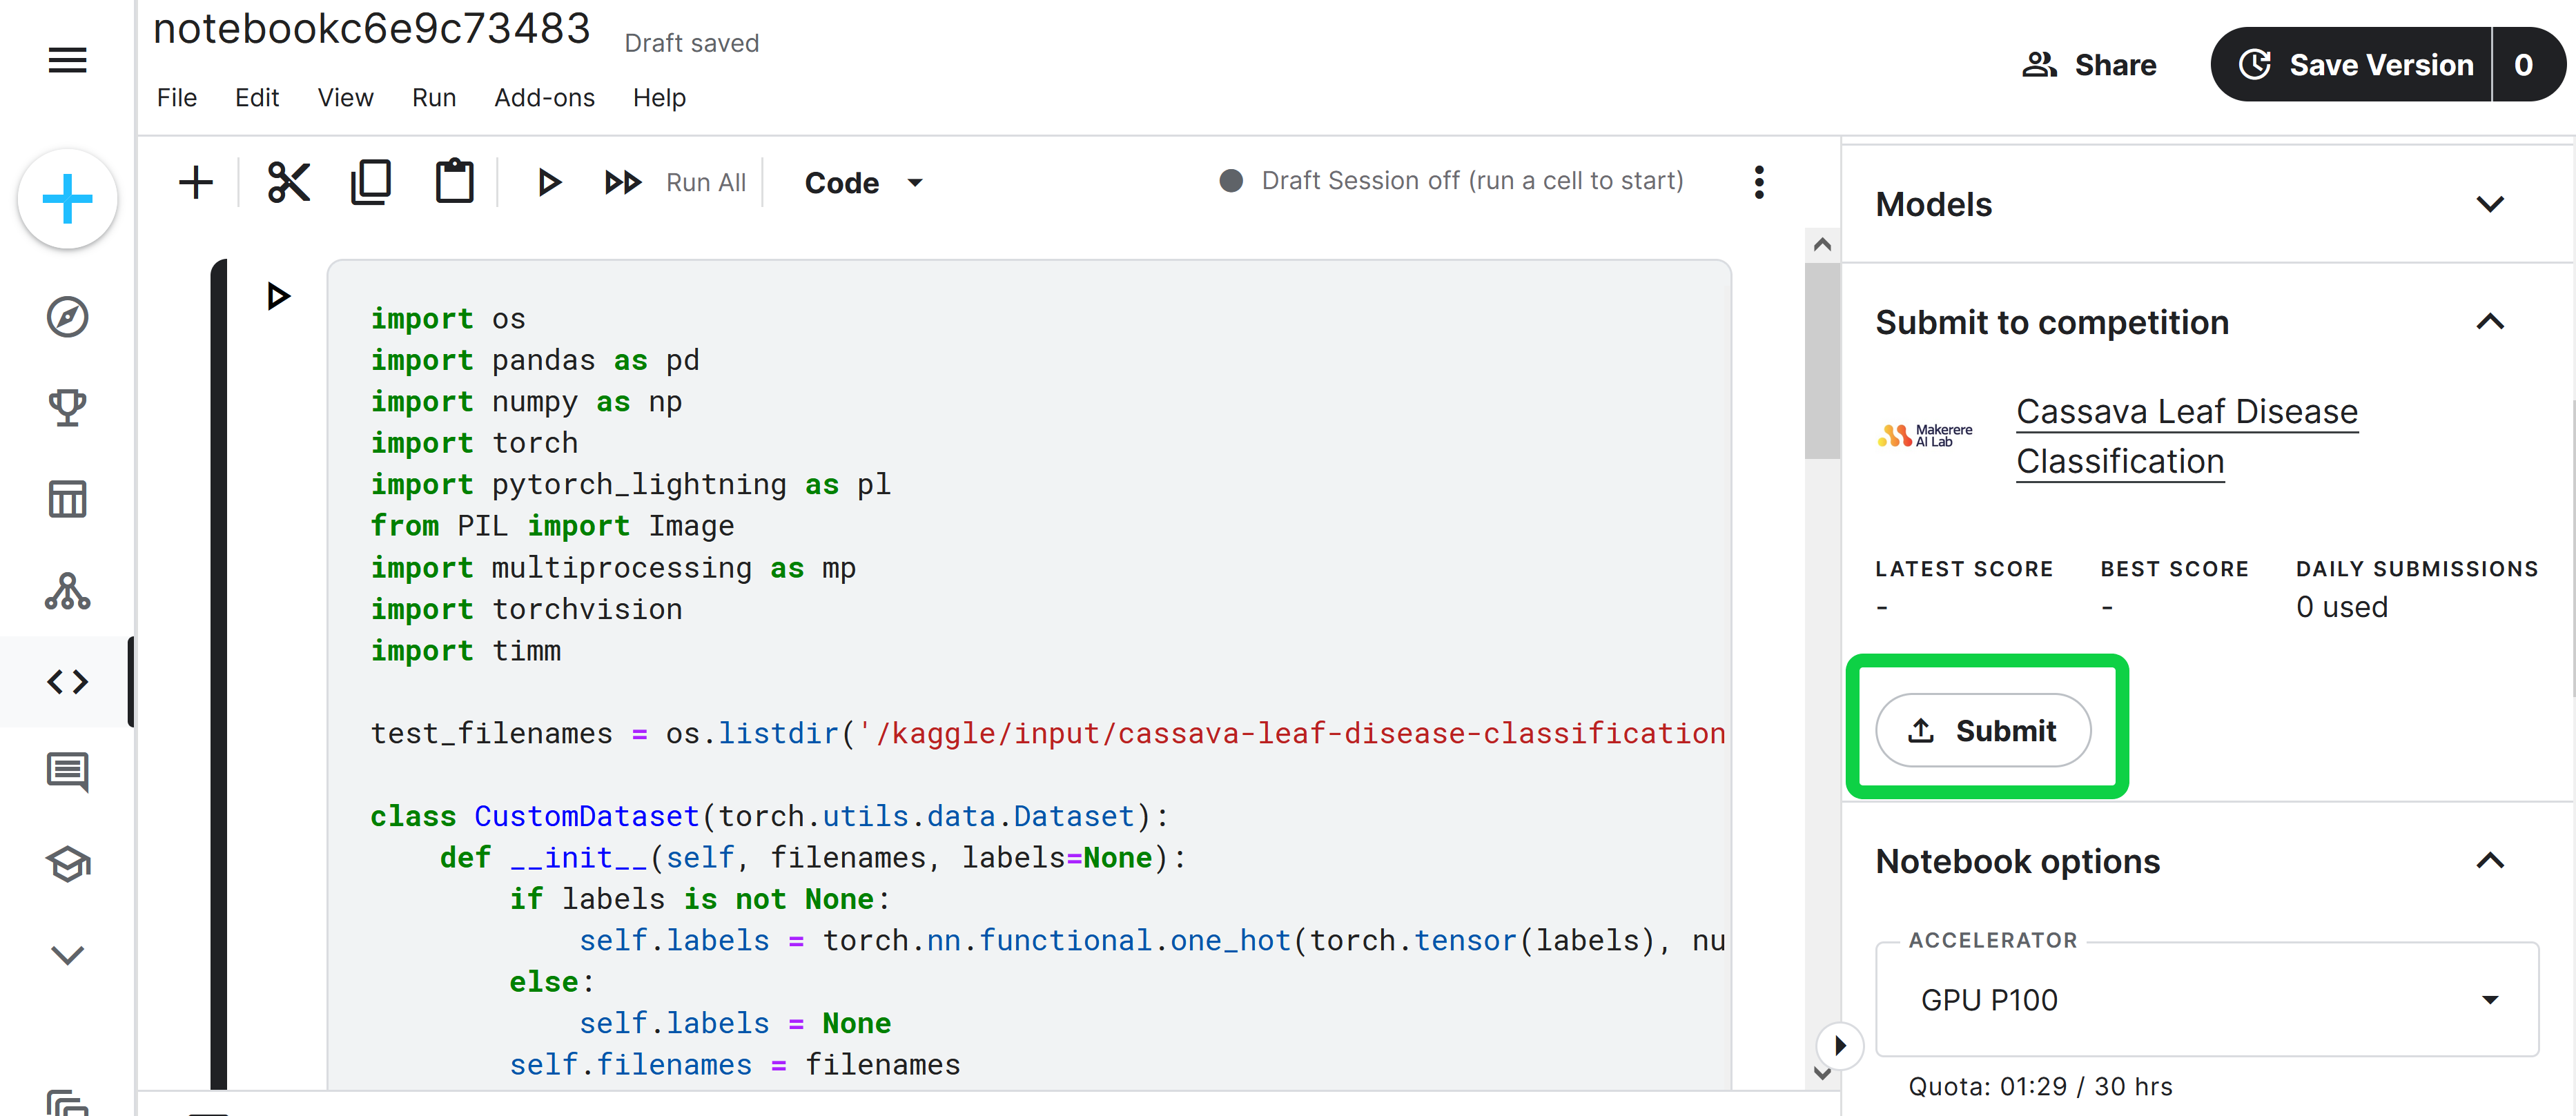

必要であれば、バージョン名と投稿の説明を入力してください。

「Submit」をクリックしてください。

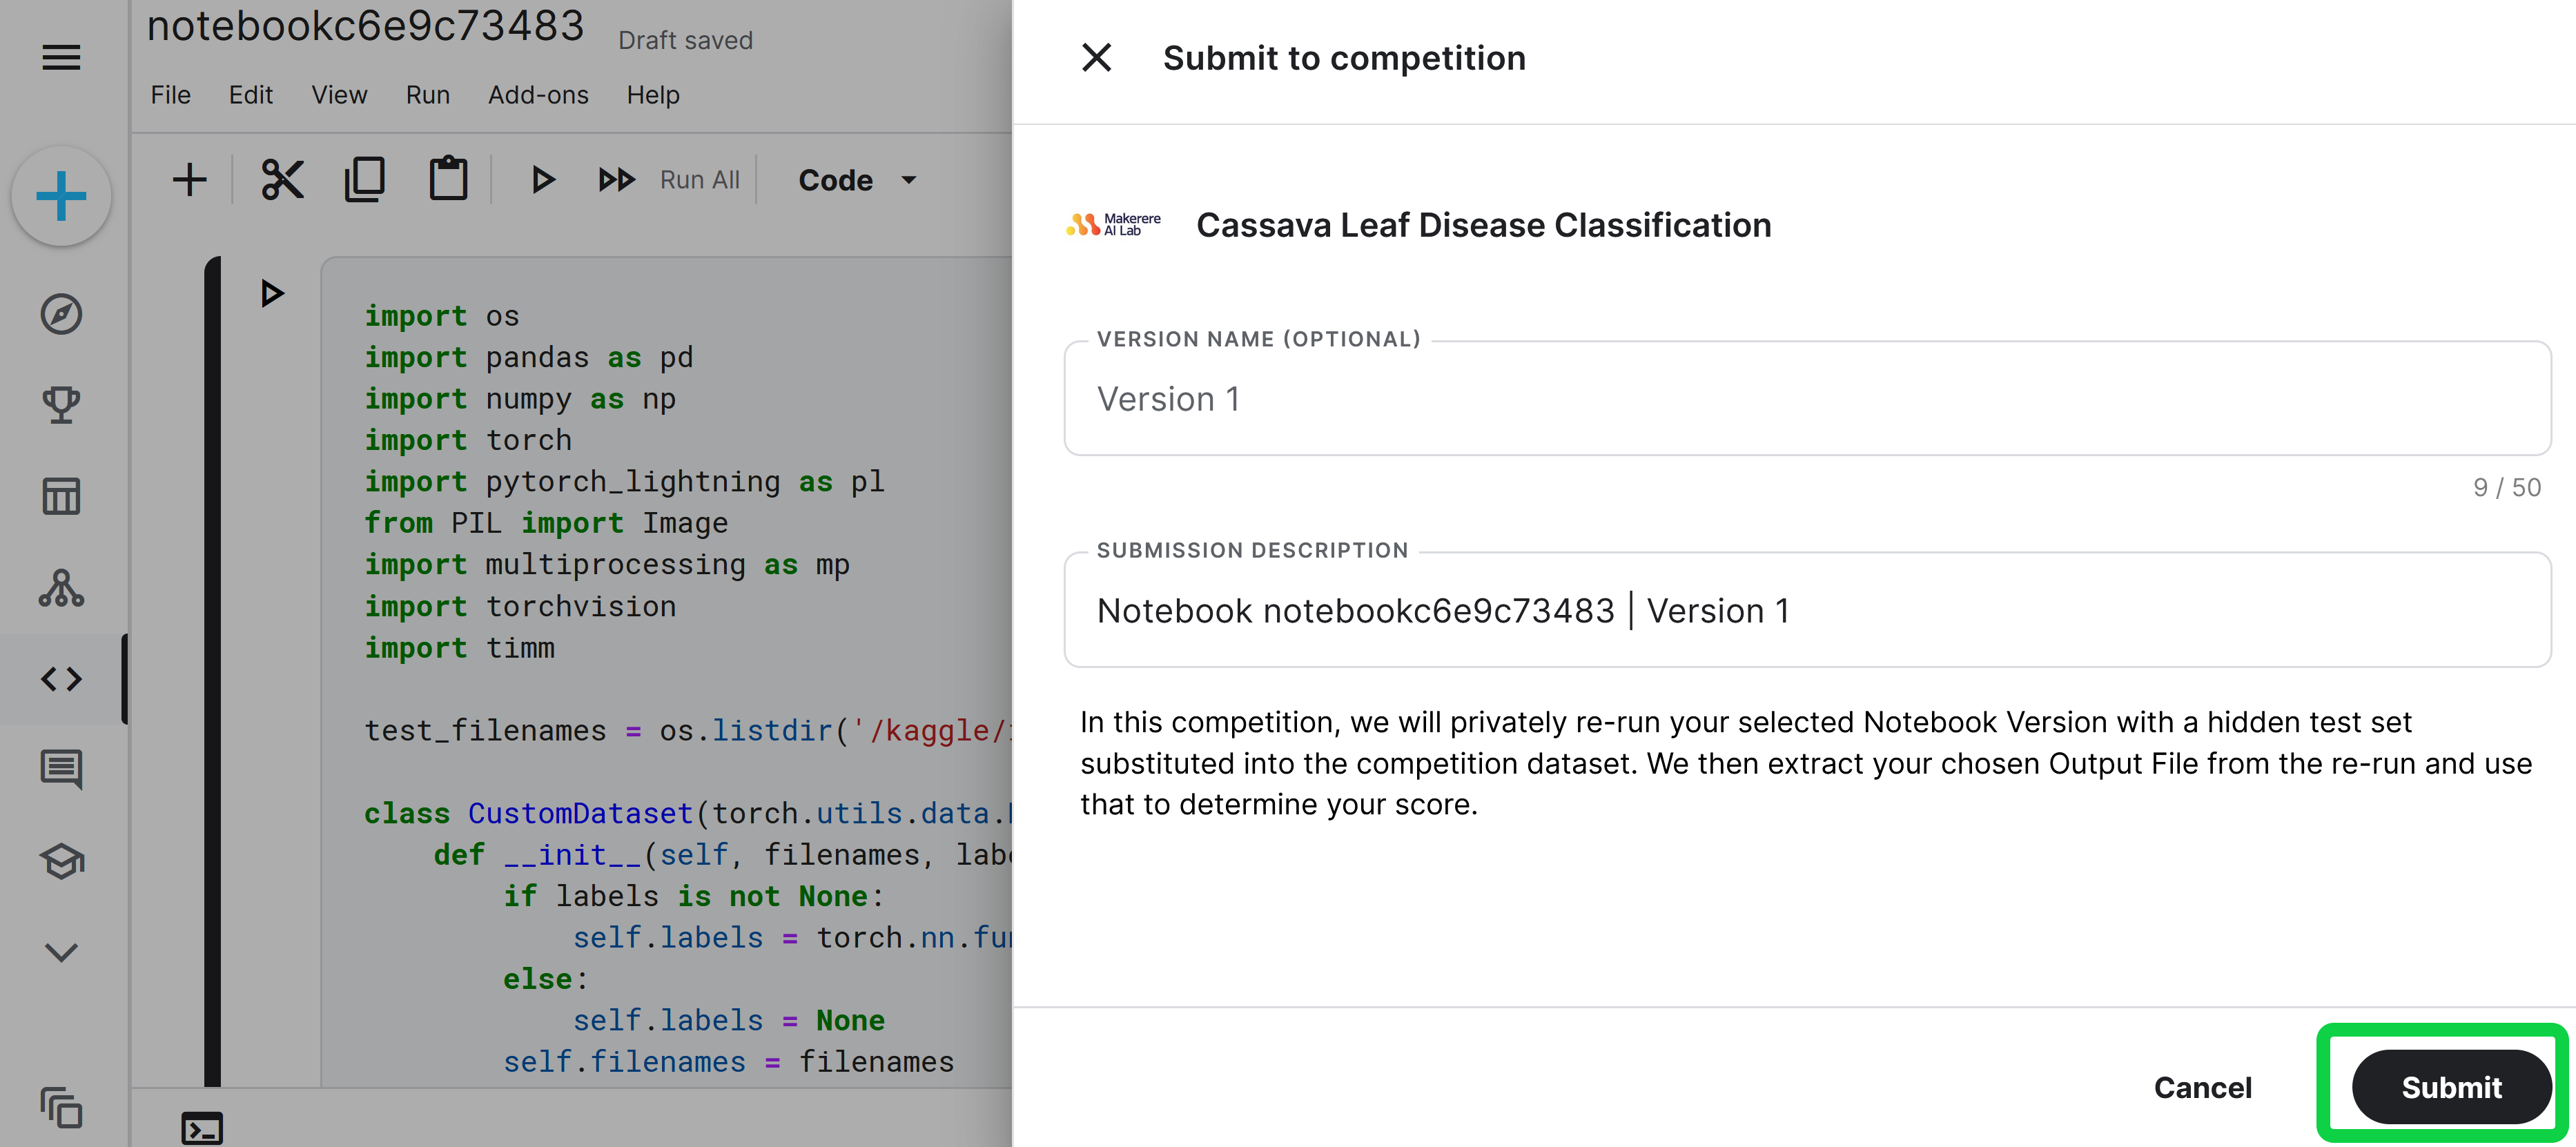

送信をクリックした後、ノートブックが正常に実行されることを確認するために、ノートブックが一度実行されます。正常に実行された場合は、全テストデータにアクセスできるコンペティション環境で再実行されます。

競技会の [提出ページ](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/submissions) をチェックして、あなたの提出物がどのように得点されたかを確認してください。投稿がページに表示され、実行が完了するまで数分かかる場合があります。

### コンペノートの更新

より高いスコアを得るために、あなたはおそらくモデルをさらに微調整してコンペティションに再提出するでしょう。そのためには、プライベートデータセットを新しい重みで更新し、新しいモデルを使うように競技用ノートブックを設定しなければなりません。

ノートブックを更新する際には、以下の画像を参考にしてください。

まず、「学習済みモデルのアップロード」セクションの最初に戻り、モデルのチェックポイントをKaggleにアップロードするコードを実行します。これにより、最新のモデル重みでデータセットが自動的に更新されます。

次に、コンペノートブックを最新モデルにアップデートする必要があります。

[コンペティションの投稿ページ](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/submissions)を開いてください。

あなたのノートブックの最新の投稿を見つけ、それをクリックして投稿されたバージョンのノートブックに移動します。

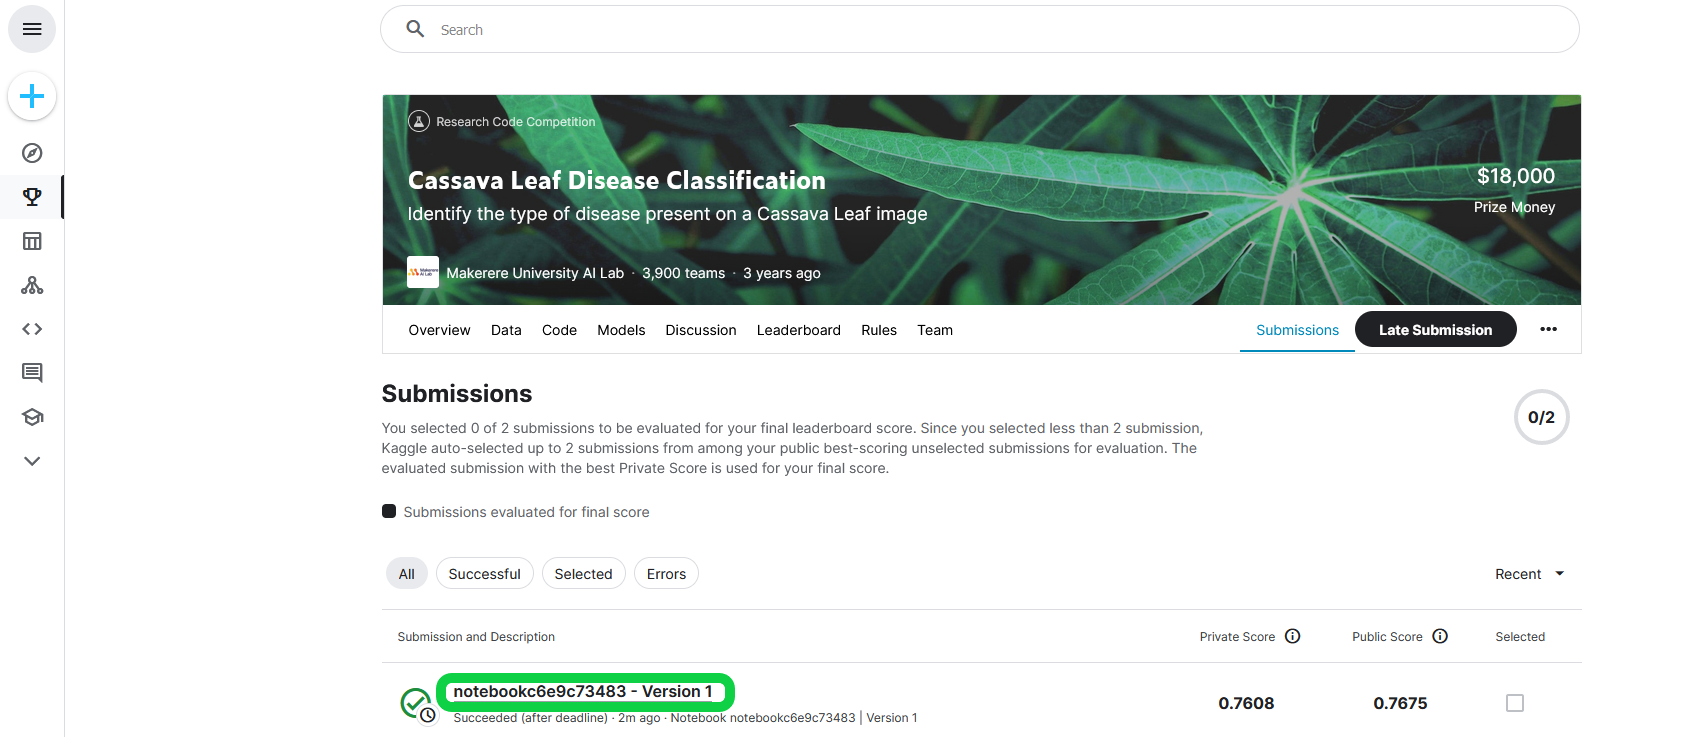

「Edit」をクリックして。

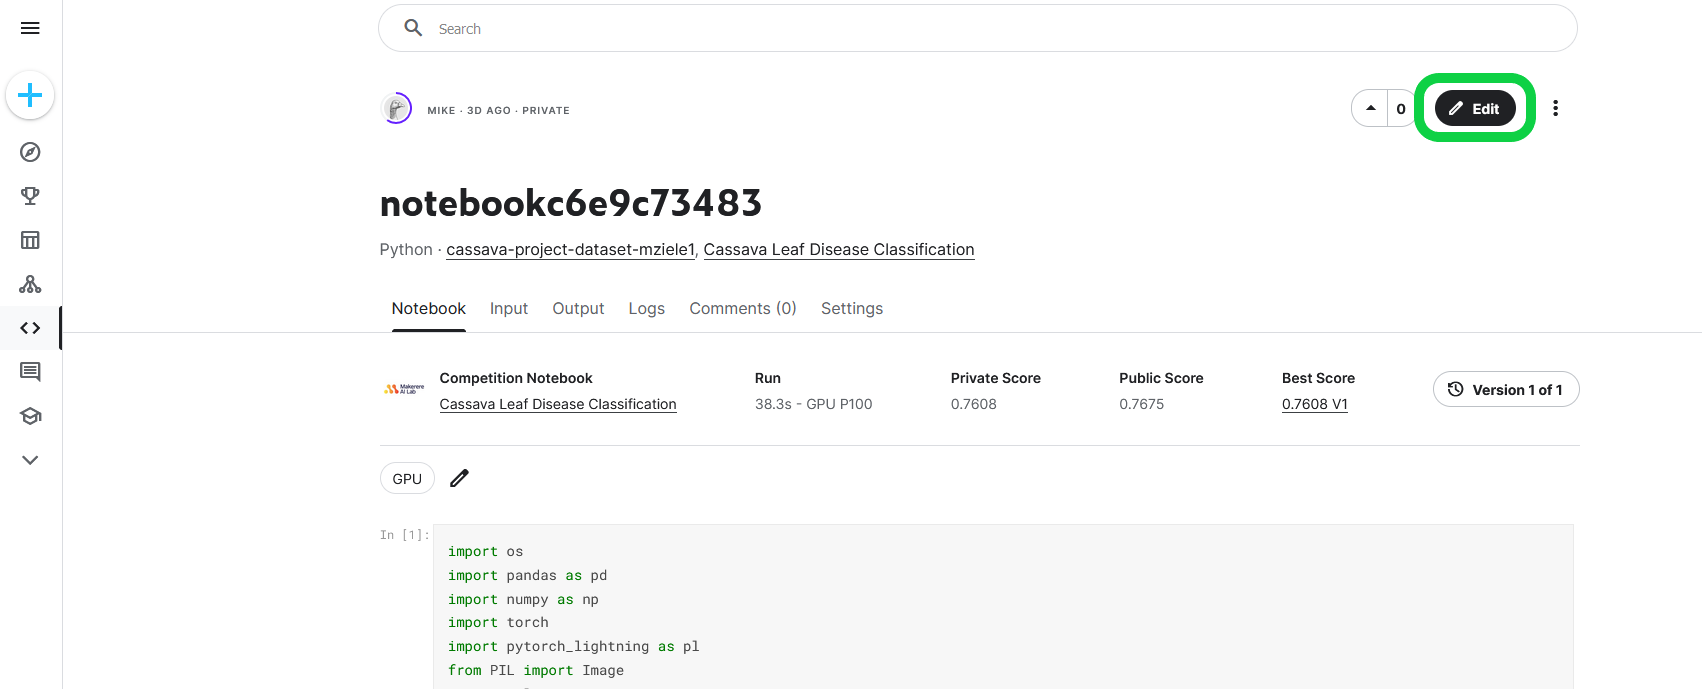

ノートブックが編集モードになります。

画面の右側の「Data」タブで、データセットを探してください。データセット名の上にカーソルを置き、縦に3つの点が表示されたら、それをクリックしてください。

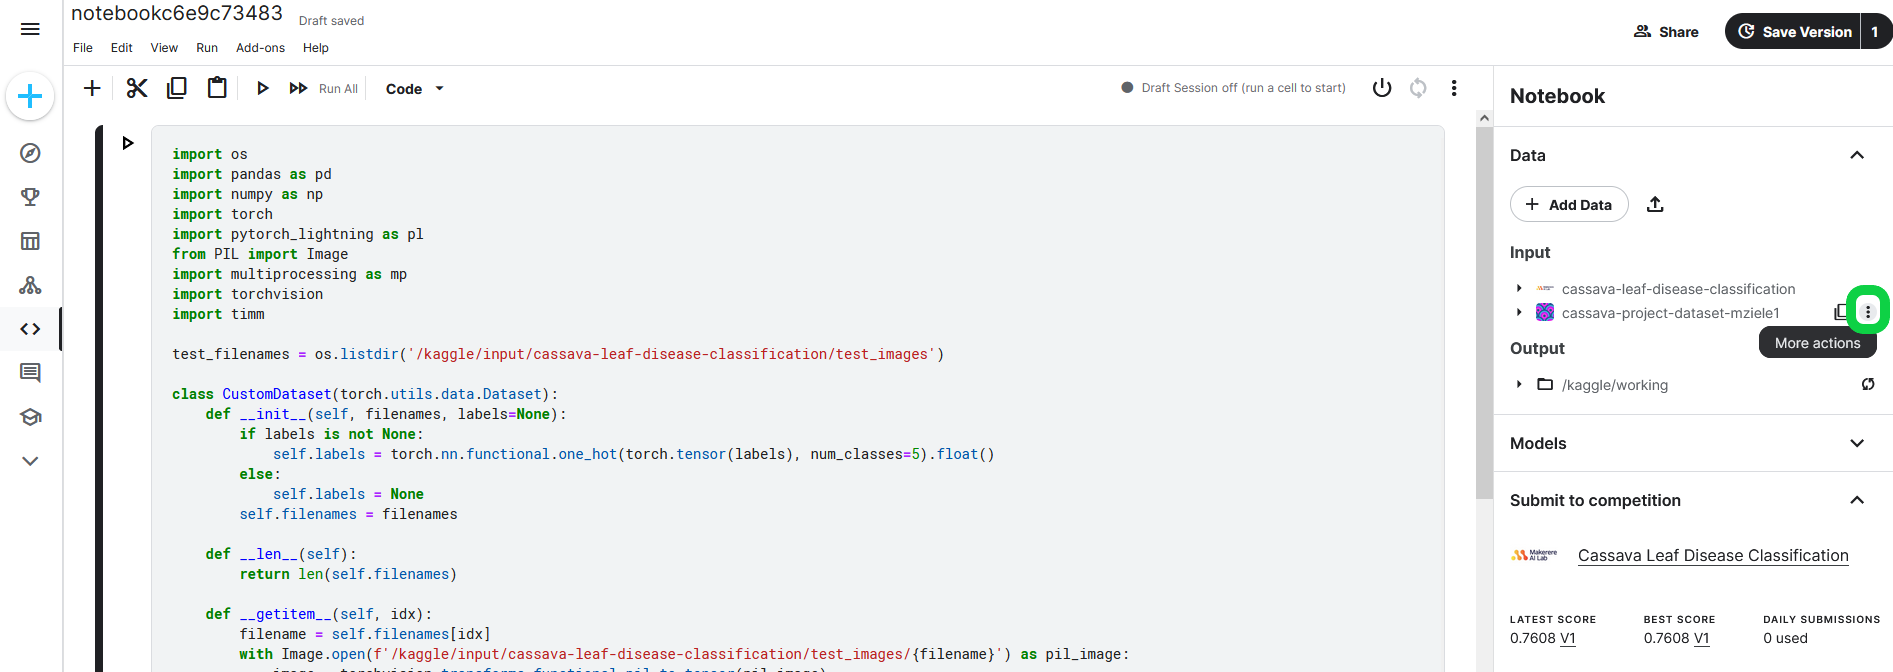

「Check for updates」をクリックして。

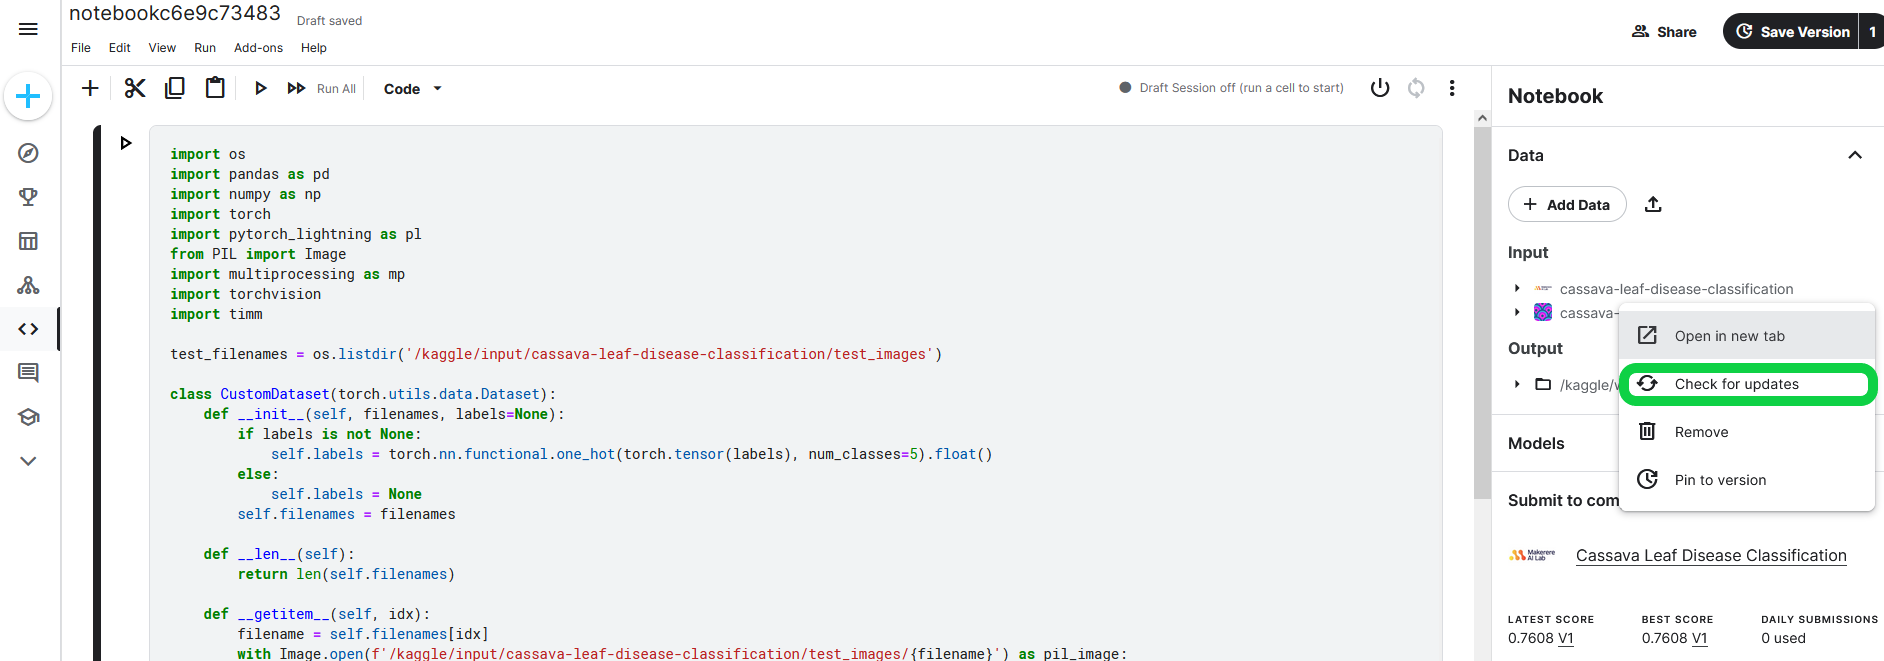

「Update」をクリックして。

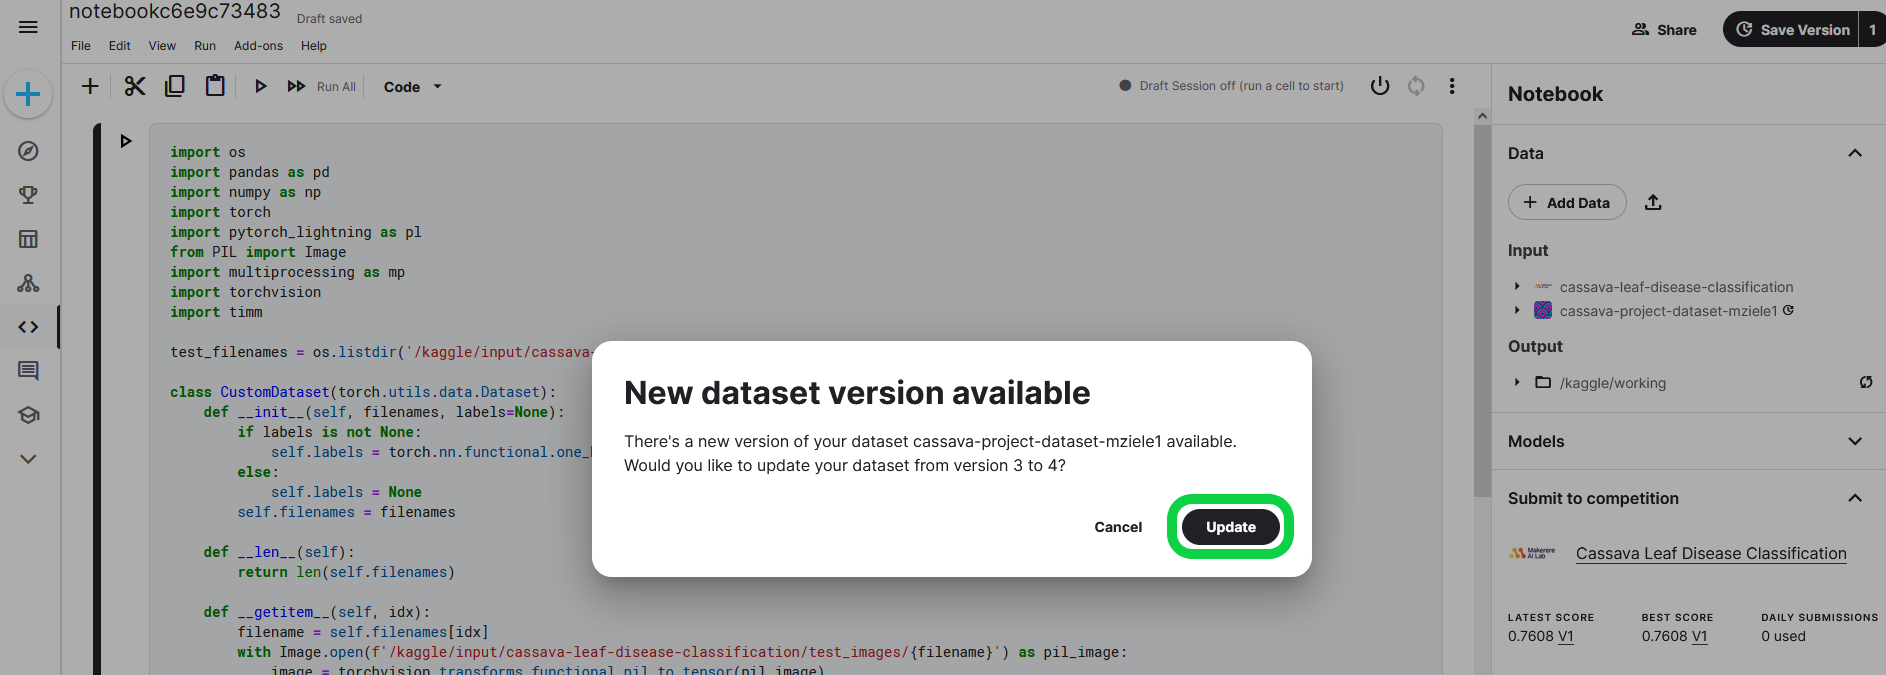

あなたのノートブックでは、最新バージョンのデータセットが使用されます。

モデルのアーキテクチャやデータの前処理方法を変更した場合は、競技用ノートブックの対応するコードも変更する必要があります。

最後に、ノートブックを提出するには、「Submit」 ボタンをクリックし、「競技用ノートブックの作成」 の最後にある手順に従ってください。

# <font color='#3E1485'>**提案**</font>

**他のモデル** - EfficientNetはかなり古いモデルで、私たちが使っているバージョンは一番小さいものです。より大きなEfficientNetsや全く別のモデルに変更することで、精度が向上するかもしれませんが、単純なモデルでもまだ許容できる精度を達成することができます。モデルのサイズとトレーニングに必要なリソースの量を考慮しながら、様々なモデルを試し、パフォーマンスを比較することは興味深いかもしれません。


**学習率** - 我々の学習率は比較的小さい。これはスコアが悪くなるオーバーフィッティングを避けるのに役立つかもしれませんが、トレーニング時間が長くなります。学習結果を観察し、学習率を上げてみてください。


**エポック** - 我々のモデルは数エポックしか学習しません。TensorBoardでトレーニングの進捗を確認すると、検証損失やメトリクスが着実に向上しているように見えますが、これはもっとトレーニングすべき指標です。エポック数を増やしてみてください。


**自動的に学習を停止する** - 多くのエポック数を学習すると、モデルの改善が止まってしまう可能性があります。PyTorch Lightning には、学習を早期に終了させる早期停止コールバックがあります。[ドキュメント](https://lightning.ai/docs/pytorch/stable/common/early_stopping.html)を確認して、学習プロセスに追加できるか確認してください。


**データ補強** - データ補強と変換は、既存の画像から "新しい "画像を作成することで、オーバーフィッティングを減らし、画像データのパフォーマンスを向上させる方法の1つです。例えば、画像を軸に沿って反転させたり、ランダムなノイズを加えたり、トリミングすることで画像を変更することができます。データ補強により、より複雑なモデルを使用しやすくなる場合もありますし、単純に現在のモデルのスコアが向上する場合もあります。